Progress So far:

We gathered some useful data sets from:

GenAge http://genomics.senescence.info/genes/

Cell Map(Yeast Genome): https://downloads.yeastgenome.org/sequence/S288C_reference/genome_releases/

Cell Map.org: https://thecellmap.org/

Data set : http://math.bu.edu/people/kolaczyk/datasets.html

Used the orthologs model to find similar genes between yeast, mice, worms, fruit flies

** TO DO **

* Need to look up Managbanag et al. (2008) "Shortest-path ..." study

* Need to formalize patterns for longevity genes/types

* Need to find protein interaction network for worm/mouse/or human


In [8]:
from copy import deepcopy
import json
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib
import matplotlib.pylab as plt
%matplotlib inline

**Load initial files**

- The 'yeast_genage_models_export.tsv' file contains the the genes which have been linked to longevity.

- The 'genage_models_orthologs_export.tsv' file contains orthologs from other species. 

Using .info() and .head() to take a look at type of data and formatting.

In [9]:
yeast_file = 'yeast_genage_models_export.tsv'
homologous_files = ['genage_models_orthologs_export.tsv']#, 'worm_genage_models_orthologs_export.tsv',
                    #'fly_genage_models_orthologs_export.tsv', 'mouse_genage_models_orthologs_export.tsv']
df_yeast = pd.read_csv(yeast_file, sep=r'\t', engine='python')

In [10]:
df_yeast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1185 entries, 0 to 1184
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gene ID                  1185 non-null   int64  
 1   Entrez Gene ID           1185 non-null   int64  
 2   Gene Symbol              1185 non-null   object 
 3   Gene Name                1185 non-null   object 
 4   Organism                 1185 non-null   object 
 5   Unigene ID               0 non-null      float64
 6   Ensembl ID               1086 non-null   object 
 7   UniProt ID               0 non-null      float64
 8   Alias                    502 non-null    object 
 9   Lifespan Effect          1177 non-null   object 
 10  Phenotype Description    1185 non-null   object 
 11  Longevity Influence      1172 non-null   object 
 12  Max Lifespan Change      23 non-null     float64
 13  Avg Lifespan Change      634 non-null    float64
 14  Method                  

In [11]:
df_yeast.head(10)

,Gene ID,Entrez Gene ID,Gene Symbol,Gene Name,Organism,Unigene ID,Ensembl ID,UniProt ID,Alias,Lifespan Effect,Phenotype Description,Longevity Influence,Max Lifespan Change,Avg Lifespan Change,Method,Bibliographic reference
0,1553,852380,AAC3,ADP/ATP Carrier,Saccharomyces cerevisiae,NaN,YBR085W,NaN,ANC3,increase,Replicative lifespan increased by 15% in the a...,anti,NaN,15.0,Deletion,"2504: Smith et al. (2008) ""Quantitative eviden..."
1,1393,855581,AAH1,Adenine AminoHydrolase,Saccharomyces cerevisiae,NaN,YNL141W,NaN,NaN,increase,Mean chronological lifespan increased in the a...,anti,NaN,NaN,Deletion,"2501: Matecic et al. (2010) ""A microarray-base..."
2,1612,853755,AAT1,Aspartate AminoTransferase,Saccharomyces cerevisiae,NaN,YKL106W,NaN,NaN,increase,Replicative lifespan increased by 25%,pro,NaN,25.0,Overexpression,"2511: Easlon et al. (2008) ""The malate-asparta..."
3,1613,850714,AAT2,Aspartate AminoTransferase,Saccharomyces cerevisiae,NaN,YLR027C,NaN,ASP5,increase,Replicative lifespan increased by 15%,pro,NaN,15.0,Overexpression,"2511: Easlon et al. (2008) ""The malate-asparta..."
4,1683,850450,ABP1,Actin Binding Protein,Saccharomyces cerevisiae,NaN,YCR088W,NaN,NaN,increase,Replicative lifespan increased by 20% in the a...,anti,NaN,20.0,Deletion,"2503: Managbanag et al. (2008) ""Shortest-path ..."
5,1683,850450,ABP1,Actin Binding Protein,Saccharomyces cerevisiae,NaN,YCR088W,NaN,NaN,decrease,Replicative lifespan decreased by 20% in the a...,fitness,NaN,20.0,Deletion,"2503: Managbanag et al. (2008) ""Shortest-path ..."
6,1683,850450,ABP1,Actin Binding Protein,Saccharomyces cerevisiae,NaN,YCR088W,NaN,NaN,increase,Replicative lifespan increased by 30% in the a...,anti,NaN,30.0,Deletion,"2504: Smith et al. (2008) ""Quantitative eviden..."
7,1683,850450,ABP1,Actin Binding Protein,Saccharomyces cerevisiae,NaN,YCR088W,NaN,NaN,decrease,Replicative lifespan decreased by 20% in the a...,fitness,NaN,20.0,Deletion,"2504: Smith et al. (2008) ""Quantitative eviden..."
8,1507,852925,ACB1,Acyl-CoA-Binding,Saccharomyces cerevisiae,NaN,YGR037C,NaN,NaN,increase,Mean replicative lifespan increased in the alp...,anti,NaN,NaN,Deletion,"2500: Fabrizio et al. (2010) ""Genome-wide scre..."
9,1914,852266,ACH1,Ach1p,Saccharomyces cerevisiae,NaN,NaN,NaN,NaN,decrease,Deletion of ACH1 reduces chronological lifespan.,fitness,NaN,NaN,Deletion,"3522: Eisenberg et al. (2014) ""Nucleocytosolic..."


Get the relevant values for our Network

In [12]:
longevity_id = [x for x in df_yeast['Ensembl ID']]
longevity_effect = [x for x in df_yeast['Longevity Influence']]
longevity_id_dict = dict(zip(longevity_id, longevity_effect))

In [13]:
interactions = 'ppi/ppi.txt'
g_list = []
with open(interactions, 'r') as f:
    for line in f:
        i = line.split('\t')
        g_list.append((i[0].strip(), i[1].strip()))

        
G = nx.Graph(g_list)

In [14]:
connected = [c for c in sorted(nx.connected_components(G), key=len, reverse=True)][0]
G_main = G.subgraph(connected).copy()

In [15]:
colors = ['#d61111','#11d646','#11c6d6','#d67711','#1b11d6','#d611cc']

for n in G_main.nodes():
    if n in longevity_id_dict:
        if longevity_id_dict[n] == 'pro':
            # green
            G_main.nodes[n]['color'] = colors[1]
            G_main.nodes[n]['group'] = 'pro'
        elif longevity_id_dict[n] == 'anti':
            # red
            G_main.nodes[n]['color'] = colors[0]
            G_main.nodes[n]['group'] = 'anti'
        elif longevity_id_dict[n] == 'fitness':
            # orange
            G_main.nodes[n]['color'] = colors[3]
            G_main.nodes[n]['group'] = 'fitness'
        elif longevity_id_dict[n] == 'unclear':
            G_main.nodes[n]['color'] = colors[2]
            G_main.nodes[n]['group'] = 'unclear'
        else:
            G_main.nodes[n]['color'] = colors[2]
    else:
        G_main.nodes[n]['color'] = colors[2]

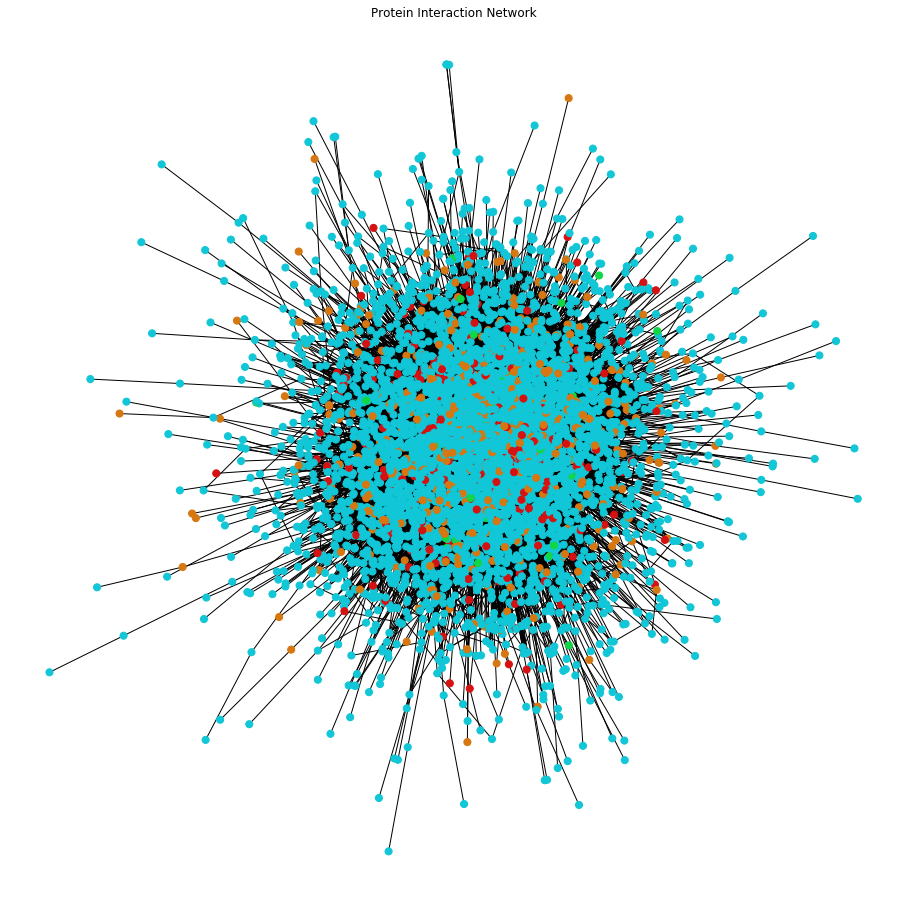

In [17]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.set_title('Protein Interaction Network')
nx.draw(G_main, pos=nx.spring_layout(G_main),
        node_size=50, 
        node_color=[G_main.nodes[n]['color'] for n in G_main.nodes()])#, ax=ax)
plt.show()

**Network Facts**

In [16]:
n = G_main.number_of_nodes()
m = G_main.number_of_edges()
k = (2*m)/n
C = nx.transitivity(G_main)

# from PS 3 
def compute_MGD(G):
    # input : a networkx graph G
    # output: the mean geodesic path length (defined in Lecture 2)
    
    # apsp is the matrix of all pairs shortest paths. It will not include infite paths. It will include 0 paths.
    apsp = dict(nx.all_pairs_shortest_path(G))
    
    # z is the number of non-infinite and non-zero pairwise distances being summed over. 
    z = 0
    # the sum of all path lengths which are non-zero and non-infinite
    sum_dist = 0
    
    for source in apsp:
        for target in apsp[source]:
            # This will remove and paths with len 0 from the apsp dict.
            if target != source:
                # using the -1 will give accurate path lengths rather than node count.
                sum_dist += len(apsp[source][target]) -1
                z += 1
    # return the mean of the shortest pairwise distances
    return sum_dist/z

ellmean = compute_MGD(G_main)


print("Overall")
print('Number of nodes: {}'.format(n))
print('Number of edges: {}'.format(m))
print('Average Degree: {}'.format(k))
print('Clustering coefficient: {}'.format(C))
print('Mean Geodesic Distance: {}'.format(ellmean))

MemoryError: 

In [ ]:
n_L = len()

In [19]:
worm_file = 'worm_genage_models_export.tsv'
df_worm = pd.read_csv(worm_file, sep=r'\t', engine='python')
df_worm.head(20)

,Gene ID,Entrez Gene ID,Gene Symbol,Gene Name,Organism,Unigene ID,Ensembl ID,UniProt ID,Alias,Lifespan Effect,Phenotype Description,Longevity Influence,Max Lifespan Change,Avg Lifespan Change,Method,Bibliographic reference
0,1,181727.0,aak-2,AMP-Activated Kinase,Caenorhabditis elegans,Cel.17479,T01C8.1,NaN,NaN,decrease,Could be a sensor that couples energy levels a...,pro,NaN,12.0,Knockout,"2232: Apfeld et al. (2004) ""The AMP-activated ..."
1,1,181727.0,aak-2,AMP-Activated Kinase,Caenorhabditis elegans,Cel.17479,T01C8.1,NaN,NaN,decrease,37% decrease in median lifespna in daf-2 backg...,pro,NaN,54.0,RNA interference,"2239: Samuelson et al. (2007) ""Gene activities..."
2,1,181727.0,aak-2,AMP-Activated Kinase,Caenorhabditis elegans,Cel.17479,T01C8.1,NaN,NaN,increases,Constitutively activated aak-2 increased worm ...,pro,NaN,NaN,Overexpression,"4423: Burkewitz et al. (2015) ""Neuronal CRTC-1..."
3,1,181727.0,aak-2,AMP-Activated Kinase,Caenorhabditis elegans,Cel.17479,T01C8.1,NaN,NaN,increase,Transgenic animals with a higher aak-2 gene do...,pro,NaN,13.0,Overexpression,"2232: Apfeld et al. (2004) ""The AMP-activated ..."
4,1,181727.0,aak-2,AMP-Activated Kinase,Caenorhabditis elegans,Cel.17479,T01C8.1,NaN,NaN,increases,Constitutively activated aak-2 increased worm ...,NaN,NaN,NaN,Overexpression,"4515: Tabrez et al. (2017) ""Differential alter..."
5,1,181727.0,aak-2,AMP-Activated Kinase,Caenorhabditis elegans,Cel.17479,T01C8.1,NaN,NaN,increases,Constitutively activated aak-2 increased worm ...,pro,NaN,NaN,Overexpression,"4515: Tabrez et al. (2017) ""Differential alter..."
6,1,181727.0,aak-2,AMP-Activated Kinase,Caenorhabditis elegans,Cel.17479,T01C8.1,NaN,NaN,increases,Constitutively activated aak-2 increased worm ...,pro,NaN,NaN,Overexpression,"4515: Tabrez et al. (2017) ""Differential alter..."
7,269,181492.0,aakb-1,AMP-Activated Kinase Beta subunit,Caenorhabditis elegans,Cel.860,F55F3.1,NaN,NaN,decrease,RNA interference resulted in decreased lifespa...,pro,NaN,NaN,RNA interference,"2290: Ha et al. (2006) ""Caenorhabditis elegans..."
8,752,176552.0,aakb-2,AMP-Activated Kinase Beta subunit,Caenorhabditis elegans,Cel.9773,Y47D3A.15,NaN,NaN,decrease,RNA interference resulted in decreased lifespa...,pro,NaN,NaN,RNA interference,"2290: Ha et al. (2006) ""Caenorhabditis elegans..."
9,1849,181736.0,aakg-2,Protein AAKG-2,Caenorhabditis elegans,NaN,NaN,NaN,NaN,increase,"aakg-2 overexpression extends mean, median, an...",pro,35,47.0,Overexpression,"2588: Sagi and Kim (2012) ""An engineering appr..."
